# MCMC example script

In the previous tuturial scripts we explored a few statistics and how they varied wehen paramters where individually varied. However, what we often want to do instead is explore the full paramters space, in this case a 6D space. Due to th high dimensionality of the input paramters this typically can't be done 'by hand'. A common approach to fit a given statistis when all 6 paramters are allowed to vary is to perform an Markov-Monte Carlo (MCMC) sampling. In this notebook will will use the pythn package `emcee` to fit the host stellar mass to that infered from abundance matching.

Let's start by import the functions we need.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import emcee

# Stellar mass halo mass relation

To start we need to specify the stellar mass halo mass relation we are going to fit to. Here we will use the relation from [Behroozi 2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.488.3143B/abstract).

Text(0, 0.5, '$M_{stel}/M_{200c}$')

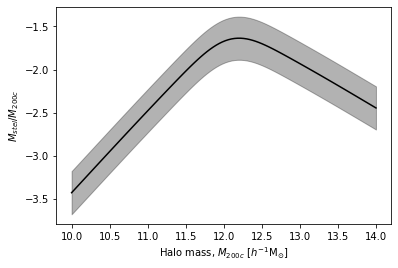

In [10]:
def SMHM(M):
    #Behroozi stellar mass function
    M_1 = 10**12.081
    eps = -1.435
    alpha = 1.957
    beta = 0.474
    sigma = 0.386
    gamma = 10**(-1.065)

    x = np.log10(M/M_1)
    M_st = eps
    M_st += -np.log10(10**(-alpha*x)+10**(-beta*x))
    M_st += gamma*np.exp(-0.5*(x/sigma)**2)
    M_st = 10**(M_st)*M_1


    std=np.ones(len(M))*0.25
    #std in dex
    return(M_st,std)

M_DM = np.logspace(10,14,100)
M_st, std = SMHM(M_DM)

plt.figure()
plt.plot(np.log10(M_DM),np.log10(M_st/M_DM),'k-')
plt.fill_between(np.log10(M_DM),np.log10(M_st/M_DM)-std,np.log10(M_st/M_DM)+std,alpha=0.3,color='black')

plt.xlabel('Halo mass, $M_{200c}$ [$h^{-1}$M$_{\\odot}$]')
plt.ylabel('$M_{stel}/M_{200c}$')